In [1]:
import pythonradex

# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file, atomic_transition
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [2]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CO from LAMBDA database
datafilepath = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\co_datafile.dat"  # file downloaded from LAMDA database


# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
line_profile_type = "Gaussian"  # line profile, can be "Gaussian",  “rectangular”,"LVG sphere", "LVG slab”
width_v = 5 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud = radiative_transfer.Cloud(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

N = 1e18 / constants.centi**2  # CO column density in m-2
Tkin = 30  # kinetic temperature in [K]

# collider densities in cm-3:
para_h2_density = 1e8
ortho_h2_density = 3e8

# collider densities in m-3 (phytonradex takes the densities in m-3):
collider_densities_LTE = {
    "para-H2": para_h2_density / constants.centi**3,
    "ortho-H2": ortho_h2_density / constants.centi**3,
}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=collider_densities_LTE,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer equation, i.e. calculate the level population with an iterative method
cloud.solve_radiative_transfer()

In [3]:
# store the data
data_co = LAMDA_file.read(datafilepath, read_frequencies=True)

# Initialize g_weigth
levels = data_co["levels"]
rad_transitions = data_co["radiative transitions"]
coll_transitions = data_co["collisional transitions"]
quantum_numbers = data_co["quantum numbers"]

g_weigth = np.array([level.g for level in levels])
g_up = np.array([gup.name for gup in rad_transitions])

In [4]:
number_level = np.array([level.number for level in levels])

In [5]:
Eu = np.array([level.E for level in levels]) / constants.k

Eu_test = np.array([level.up.E for level in rad_transitions]) / constants.k

In [6]:
Eu

array([   0.        ,    5.53214517,   16.59617609,   33.19188137,
         55.31833031,   82.974736  ,  116.16031175,  154.87340764,
        199.11280441,  248.87685379,  304.16332873,  364.97043585,
        431.29580629,  503.13678297,  580.49056589,  663.35449669,
        751.72520052,  845.599158  ,  944.97313597, 1049.84303913,
       1160.20491752, 1276.0546769 , 1397.3877882 , 1524.19972692,
       1656.48539072, 1794.2399659 , 1937.45806361, 2086.1342947 ,
       2240.26298185, 2399.83801775, 2564.8534387 , 2735.3029919 ,
       2911.18013782, 3092.47804981, 3279.18990371, 3471.30844029,
       3668.82625666, 3871.73609478, 4080.02983772, 4293.69964515,
       4512.73740391])

In [7]:
Eu_test

array([   5.53214517,   16.59617609,   33.19188137,   55.31833031,
         82.974736  ,  116.16031175,  154.87340764,  199.11280441,
        248.87685379,  304.16332873,  364.97043585,  431.29580629,
        503.13678297,  580.49056589,  663.35449669,  751.72520052,
        845.599158  ,  944.97313597, 1049.84303913, 1160.20491752,
       1276.0546769 , 1397.3877882 , 1524.19972692, 1656.48539072,
       1794.2399659 , 1937.45806361, 2086.1342947 , 2240.26298185,
       2399.83801775, 2564.8534387 , 2735.3029919 , 2911.18013782,
       3092.47804981, 3279.18990371, 3471.30844029, 3668.82625666,
       3871.73609478, 4080.02983772, 4293.69964515, 4512.73740391])

In [8]:
for i, tran in enumerate(rad_transitions):
    gu = tran.up.g
    Eu = tran.up.E
    print(f"Transition {i}:")
    print("Statistical weight of upper level ", gu)
    print("Energy of upper level Eu", Eu / constants.k)
    print()

print("statsitical weight of upper level ", gu)
print("Energy of upper level Eu", Eu / constants.k)

Transition 0:
Statistical weight of upper level  3.0
Energy of upper level Eu 5.532145167854433

Transition 1:
Statistical weight of upper level  5.0
Energy of upper level Eu 16.596176090653508

Transition 2:
Statistical weight of upper level  7.0
Energy of upper level Eu 33.19188137466572

Transition 3:
Statistical weight of upper level  9.0
Energy of upper level Eu 55.31833030822088

Transition 4:
Statistical weight of upper level  11.0
Energy of upper level Eu 82.97473600266304

Transition 5:
Statistical weight of upper level  13.0
Energy of upper level Eu 116.16031175493842

Transition 6:
Statistical weight of upper level  15.0
Energy of upper level Eu 154.8734076419077

Transition 7:
Statistical weight of upper level  17.0
Energy of upper level Eu 199.11280441095295

Transition 8:
Statistical weight of upper level  19.0
Energy of upper level Eu 248.8768537863343

Transition 9:
Statistical weight of upper level  21.0
Energy of upper level Eu 304.1633287284865

Transition 10:
Statis

In [9]:
g_up[0]

np.str_('1-0')

In [10]:
def extract_upper_number(np_str):
    return int(np_str.split("-")[0])


# Example usage
first_number = extract_upper_number(g_up[0])

print(first_number)  # Output: 1

1


In [11]:
g_weigth

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25.,
       27., 29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51.,
       53., 55., 57., 59., 61., 63., 65., 67., 69., 71., 73., 75., 77.,
       79., 81.])

# Testing methanol 

In [76]:
# pyhonradex needs a file containing the atomic data, import it, this is a specific file for CO from LAMBDA database
datafilepath = (
    r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\a_ch3oh.dat"  # file downloaded from LAMDA database
)


# define the geometry of the nebula
geometry = "uniform sphere"

# define the parameters of the nebula
line_profile_type = "Gaussian"  # line profile, can be "Gaussian",  “rectangular”,"LVG sphere", "LVG slab”
width_v = 5 * constants.kilo  # line width in m/s, costants.kilo is 1 km/s

cloud = radiative_transfer.Cloud(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)

N = 1e18 / constants.centi**2  # CO column density in m-2
Tkin = 150  # kinetic temperature in [K]

# collider densities in cm-3:
para_h2_density = 1e8
ortho_h2_density = 3e8

# collider densities in m-3 (phytonradex takes the densities in m-3):
LTE_collider_densities_h2only = {"H2": 1e6 / constants.centi**3}

# define the background radiation field, in this case we assume that the background is zero, z is the redshift
ext_background = helpers.generate_CMB_background(z=0)

# no dust:
T_dust = 0
tau_dust = 0

# use high colliders density to simulate LTE
cloud.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)

# solve the radiative trasfer equation, i.e. calculate the level population with an iterative method
cloud.solve_radiative_transfer()

5-4: tau_nu0 = -0.506
7-6: tau_nu0 = -0.422
10-9: tau_nu0 = -0.185
13-12: tau_nu0 = -0.203
18-17: tau_nu0 = -0.182
24-23: tau_nu0 = -0.162
74-73: tau_nu0 = -14
33-32: tau_nu0 = -0.142
64-62: tau_nu0 = -16
42-39: tau_nu0 = -0.115
135-134: tau_nu0 = -4.18e-05
53-52: tau_nu0 = -0.0835
133-131: tau_nu0 = -4.2
134-132: tau_nu0 = -4.22
27-23: tau_nu0 = -22.1
64-61: tau_nu0 = -0.0431
87-86: tau_nu0 = -12.2
101-100: tau_nu0 = -0.0118
75-72: tau_nu0 = -15.4
116-113: tau_nu0 = -0.0193
150-147: tau_nu0 = -2.16
151-146: tau_nu0 = -2.2
34-32: tau_nu0 = -21.2
2-1: tau_nu0 = -0.0847
135-128: tau_nu0 = -0.0282
100-97: tau_nu0 = -11.1
88-85: tau_nu0 = -14.1
113-112: tau_nu0 = -7.66
47-39: tau_nu0 = -19
101-96: tau_nu0 = -11.2
128-127: tau_nu0 = -2.73
56-52: tau_nu0 = -15.3
116-111: tau_nu0 = -9.1
67-61: tau_nu0 = -4.48
135-126: tau_nu0 = -4.87
246-244: tau_nu0 = -1.88e-09
247-245: tau_nu0 = -1.87e-09
240-238: tau_nu0 = -2.45e-08
241-239: tau_nu0 = -2.59e-08
232-230: tau_nu0 = -4.99e-08
233-231: tau_nu0

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'
c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


In [77]:
# store the data
data = LAMDA_file.read(datafilepath, read_frequencies=False, read_quantum_numbers=True)

# Initialize g_weigth
levels = data["levels"]
rad_transitions = data["radiative transitions"]
coll_transitions = data["collisional transitions"]
quantum_numbers = data["quantum numbers"]


In [78]:
# selected_quantum_numbers_with_indices = [(i, qn) for i, qn in enumerate(quantum_numbers) if qn.split("_")[1] == "1"]
# indices = [i for i, qn in selected_quantum_numbers_with_indices]
# print(indices)

In [ ]:
class MyClass:
    def __init__(self, cloud_name, data_of_molecule, column_density_species, width_v, Tkin):
        """
        Initialize the class with the cloud object, the data of the molecule, the column density of the species, the width of the line and the kinetic temperature.

        Parameters
        ----------
        cloud_name : pythonradex.Cloud
            The cloud object.
        data_of_molecule : dict
            The data of the molecule. It should contain the levels, radiative transitions, quantum numbers, and the molecule name. This is the output of the LAMDA_file.read_file() function.
        column_density_species : float
            The column density of the species in m^2.
        width_v : float
            The width of the line in m/s
        Tkin : float
            The kinetic temperature in [K].
        """
        self.cloud_name = cloud_name
        self.data_of_molecule = data_of_molecule
        self.column_density_species = column_density_species
        self.width_v = width_v
        self.Tkin = Tkin
        self.extract_and_calculate(debug=False)  # this allows optical_depth to use the extracted values from the extract_and_calculate method

    def get_transition_populations(self, names_transitions, debug=False):
        """
        Relates all the transitions in names_transitions with their corresponding population densities.

        Parameters
        ----------
        names_transitions: (list of str):
            List of transitions in the format ['79-78', '14-13', ...], where each element is a string with the format "upper_level-lower_level".

        Returns
        -------
            tuple: Two arrays, one for upper and one for lower populations density.
        """
        upper_populations = []
        lower_populations = []
        self.upper_level_transition_index = []
        self.lower_level_transition_index = []
        if debug:
            print("num_transitions:", len(names_transitions))

        for transition in names_transitions:
            upper_level, lower_level = map(int, transition.split("-"))  # split the string and convert to integers
            upper_pop = self.cloud_name.level_pop[upper_level]
            lower_pop = self.cloud_name.level_pop[lower_level]
            upper_populations.append(upper_pop)
            lower_populations.append(lower_pop)
            self.upper_level_transition_index.append(upper_level)
            self.lower_level_transition_index.append(lower_level)

        nu = np.array(upper_populations)
        nl = np.array(lower_populations)
        # compute upper level population density, given by: fractional population density x total column density
        Nu = nu * self.column_density_species
        Nl = nl * self.column_density_species
        return Nu, Nl

    def extract_and_calculate(self, debug=False):
        """
        Extract values from the cloud object and the data file, and calculate gamma factor

        Parameters
        ----------
        debug : boolean, optional
            If True, print debugging information. Default is False.

        Returns
        --------
        Tex: np.array
            The excitation temperature of the molecule.
        tau: np.array
            The optical depth of the transitions.
        Aul : np.array
            The Einstein coefficient for spontaneous emission [s^-1].
        Bul : np.array
            The Einstein coefficient for stimulated emission in [sr m2 Hz / Jy].
        nu0_array : np.array
            The rest frequency of the transition in Hz.
        Eu : np.array
            The energy of the upper level in [K].
        gu : np.array
            The statistical weight of the upper level.
        gamma: np.array
            Gamma factors, which is calculated using: gamma = (8 * np.pi * k * nu0**2) / (h * c**3 * Aul)
        Nu: np.array
            Upper level population density in [m-2].
        Nl: np.array
            Lower level population density in [m-2].
        FWHM_each_transition: np.array
            Frequency width of each transition in [Hz].
        """
        # Extract values
        self.Tex = self.cloud_name.Tex
        self.Aul = self.cloud_name.emitting_molecule.A21
        self.Bul = self.cloud_name.emitting_molecule.B21
        self.nu0_array = self.cloud_name.emitting_molecule.nu0
        self.tau = self.cloud_name.tau_nu(self.nu0_array)

        # levels = self.data_of_molecule["levels"]
        rad_transitions = self.data_of_molecule["radiative transitions"]

        # Extract upper energy levels in [J] and convert to Kelvin
        self.Eu = np.array([transition.up.E for transition in rad_transitions]) / constants.k

        # Get the statistical weight of the upper and lower levels
        self.gu = np.array([transition.up.g for transition in rad_transitions])
        self.glow = np.array([transition.low.g for transition in rad_transitions])

        # Get names of transitions
        names_transitions = np.array([tran.name for tran in rad_transitions])

        # Compute upper and lower level population densities
        self.Nu, self.Nl = self.get_transition_populations(names_transitions, debug=debug)

        # Convert velocity width to frequency width
        self.FWHM_each_transition = self.nu0_array * (self.width_v / constants.c)

        # Calculate gamma factor
        self.gamma = (8 * np.pi * constants.k * self.nu0_array**2) / (constants.h * constants.c**3 * self.Aul)

        if debug:
            # Debugging print statements
            print("Size of nu0_array:", len(self.nu0_array))
            print("Size of Eu:", len(self.Eu))
            print("E upper levels:", self.Eu)
            print("Size of gu:", len(self.gu))
            print("size exitation temperature Tex:", len(self.Tex))
            print(" gu:", self.gu)
            print("Size of glow:", len(self.glow))
            print(" glow:", self.glow)
            print("size Aul:", len(self.Aul))
            print("size FWHM_each_transition:", len(self.FWHM_each_transition))
            print("size gamma:", len(self.gamma))
            print("size Nu:", len(self.Nu))
            print("size Nl:", len(self.Nl))

        return (
            self.Tex,
            self.tau,
            self.Aul,
            self.Bul,
            self.nu0_array,
            self.Eu,
            self.gu,
            self.glow,
            self.gamma,
            self.Nu,
            self.Nl,
            self.FWHM_each_transition,
        )

    def get_selected_variables(self, k_quantum_number, j_lower_limit, j_upper_limit, debug=False):
        """
        Returns the variables in extract_and_calculate which have indices selected by the given k_quantum_number and J quantum number range.

        Parameters
        ----------
        k_quantum_number : str
            The k quantum number to filter the quantum numbers.
        j_lower_limit : int
            The ending J quantum number for filtering.
        j_upper_limit : int
            The starting J quantum number for filtering.
        debug : boolean, optional
            If True, print debugging information. Default is False.

        Returns
        -------
        dict
            Dictionary containing the selected variables.
        """
        indices = [
            i
            for i, (upper_transition, lower_transition) in enumerate(zip(self.upper_level_transition_index, self.lower_level_transition_index))
            if self.data_of_molecule["quantum numbers"][upper_transition].split("_")[1]
            == k_quantum_number  # this line is to ensure that the k quantum number is the specified value
            and j_lower_limit
            <= int(self.data_of_molecule["quantum numbers"][upper_transition].split("_")[0])
            <= j_upper_limit  # this line is to ensure that the J quantum number is within the specified range
            and np.abs(
                int(self.data_of_molecule["quantum numbers"][upper_transition].split("_")[1])
                - int(self.data_of_molecule["quantum numbers"][lower_transition].split("_")[1])
            )
            in [0, 1]  # this line is to ensure that the k quantum number difference is 0 or 1
            and np.abs(
                int(self.data_of_molecule["quantum numbers"][upper_transition].split("_")[0])
                - int(self.data_of_molecule["quantum numbers"][lower_transition].split("_")[0])
            )
            in [0, 1]  # this line is to ensure that the J quantum number difference is 0 or 1
        ]
        if debug:
            print("Indices of the transitions that have the selected k quantum number and J range", indices)
            print("upper level transition index", self.upper_level_transition_index)
            print("lower level transition index", self.lower_level_transition_index)

        # selected all the variable that have the specified k quantum number
        selected_vars = {
            "Tex": self.Tex[indices],
            "tau": self.tau[indices],
            "Aul": self.Aul[indices],
            "Bul": self.Bul[indices],
            "nu0_array": self.nu0_array[indices],
            "Eu": self.Eu[indices],
            "gu": self.gu[indices],
            "glow": self.glow[indices],
            "gamma": self.gamma[indices],
            "Nu": self.Nu[indices],
            "Nl": self.Nl[indices],
            "FWHM_each_transition": self.FWHM_each_transition[indices],
        }
        return selected_vars

    def optical_depth(self):
        """
        Calculate the optical depth of a transition using the different approaches.
        In both method the change of optical depth over the line profile is not taken into account

        Returns
        -------
        tau_with_correction_factor : np.array
              Optical depth computed with the correction factor for gaussian line profile function.
        tau_without_correction_factor : np.array
              Optical depth computed without the correction factor for gaussian line profile function.
        """
        # Ensure extract_and_calculate has been called,
        if not hasattr(self, "Tex"):  # checks if the instance variable Tex has already been set, returns True if the object already has an attribute.
            self.extract_and_calculate()

        conversion_factor = np.sqrt(np.pi) / (2 * np.sqrt(np.log(2)))  ## approx. 1.0645
        # Equation used in RADEX, with correction factor for gaussian line profile function
        tau_with_correction_factor = (
            (constants.c**2 / (8 * np.pi * self.nu0_array**2))
            * self.Aul
            * ((self.Nl * self.gu / self.glow) - self.Nu)
            / (conversion_factor * self.FWHM_each_transition)
        )
        # Equation used in RADEX, without correction factor for gaussian line profile function
        tau_without_correction_factor = (
            (constants.c**2 / (8 * np.pi * self.nu0_array**2)) * self.Aul * ((self.Nl * self.gu / self.glow) - self.Nu) / self.FWHM_each_transition
        )

        return tau_with_correction_factor, tau_without_correction_factor

In [80]:
# Get names of transitions
names_transitions = np.array([tran.name for tran in rad_transitions])
upper_transitions = []
lower_transitions = []

for transition in names_transitions:
    upper_level, lower_level = map(int, transition.split("-"))  # split the string and convert to integers
    upper_transitions.append(upper_level)
    lower_transitions.append(lower_level)

print("index upper tran", upper_transitions[:10])
print("index lower tran", lower_transitions[:10])

index upper tran [5, 73, 86, 97, 7, 112, 127, 10, 141, 17]
index lower tran [4, 72, 85, 96, 6, 111, 126, 9, 140, 16]


In [81]:
selected_quantum_numbers_with_indices = [(i, qn) for i, qn in enumerate(data["quantum numbers"]) if qn.split("_")[1] == "0"]
indices = [i for i, qn in selected_quantum_numbers_with_indices]
print(indices)

[0, 1, 2, 3, 8, 11, 16, 27, 34, 47, 56, 67, 80, 95, 110, 125]


In [82]:
data["quantum numbers"]

['0_0',
 '1_0',
 '2_0',
 '3_0',
 '1_1',
 '1_-1',
 '2_1',
 '2_-1',
 '4_0',
 '3_1',
 '3_-1',
 '5_0',
 '4_1',
 '4_-1',
 '2_-2',
 '2_2',
 '6_0',
 '5_1',
 '5_-1',
 '3_-2',
 '3_2',
 '4_-2',
 '4_2',
 '6_1',
 '6_-1',
 '3_-3',
 '3_3',
 '7_0',
 '5_-2',
 '5_2',
 '4_-3',
 '4_3',
 '7_1',
 '7_-1',
 '8_0',
 '5_-3',
 '5_3',
 '6_-2',
 '6_2',
 '8_1',
 '6_-3',
 '6_3',
 '8_-1',
 '7_-2',
 '7_2',
 '4_4',
 '4_-4',
 '9_0',
 '7_3',
 '7_-3',
 '5_4',
 '5_-4',
 '9_1',
 '9_-1',
 '8_-2',
 '8_2',
 '10_0',
 '6_-4',
 '6_4',
 '8_3',
 '8_-3',
 '10_1',
 '9_-2',
 '9_2',
 '10_-1',
 '7_4',
 '7_-4',
 '11_0',
 '9_-3',
 '9_3',
 '8_4',
 '8_-4',
 '10_-2',
 '10_2',
 '11_1',
 '11_-1',
 '5_5',
 '5_-5',
 '10_3',
 '10_-3',
 '12_0',
 '9_4',
 '9_-4',
 '6_5',
 '6_-5',
 '11_-2',
 '11_2',
 '12_1',
 '12_-1',
 '7_5',
 '7_-5',
 '11_3',
 '11_-3',
 '10_4',
 '10_-4',
 '13_0',
 '12_-2',
 '12_2',
 '8_5',
 '8_-5',
 '13_1',
 '13_-1',
 '12_3',
 '12_-3',
 '11_-4',
 '11_4',
 '9_-5',
 '9_5',
 '6_6',
 '6_-6',
 '14_0',
 '13_-2',
 '13_2',
 '14_1',
 '7_6',

In [83]:
names_transitions

array(['5-4', '73-72', '86-85', ..., '213-161', '250-238', '251-239'],
      dtype='<U7')

In [84]:
data["quantum numbers"][upper_transition].split("_")[1] == 0

NameError: name 'upper_transition' is not defined

In [ ]:
# Get names of transitions
names_transitions = np.array([tran.name for tran in rad_transitions])
upper_level_transition_index = []

for transition in names_transitions:
    upper_level, lower_level = map(int, transition.split("-"))  # split the string and convert to integers
    upper_level_transition_index.append(upper_level)

# Check if the quantum number of the upper transition is equal to 1
selected_indices_in_radiative_tran = [
    i for i, upper_transition in enumerate(upper_level_transition_index) if quantum_numbers[upper_transition].split("_")[1] == "0"
]

print(selected_indices_in_radiative_tran)


[30, 32, 53, 55, 71, 77, 93, 99, 114, 128, 161, 175, 200, 220, 233, 254, 263, 294, 310, 359, 397, 438, 503, 551]


In [102]:
Tkin = 150  # kinetic temperature in [K]

# extract the data from the cloud object and the data file
CH3OH_instance = MyClass(cloud, data, N, width_v, Tkin)

TexCH3OH, tauCH3OH, AulCH3OH, BulCH3OH, nu0_arrayCH3OH, EuCH3OH, gCH3OH, glow_CH3OH, gammaCH3OH, NuCH3OH, NlCH3OH, FWHMCH3OH = (
    CH3OH_instance.extract_and_calculate(debug=True)
)

# calculate the optical depth of a transition using the different approaches
tau_radex_CH3OH, tau_pythonRADEX_approx_CH3OH = CH3OH_instance.optical_depth()

num_transitions: 1853
Size of nu0_array: 1853
Size of Eu: 1853
E upper levels: [  16.8811691   165.40178984  190.94007941 ...  659.39878072 1219.4697293
 1219.47001705]
Size of gu: 1853
size exitation temperature Tex: 1853
 gu: [ 3. 21. 23. ... 23. 29. 29.]
Size of glow: 1853
 glow: [ 3. 21. 23. ... 21. 27. 27.]
size Aul: 1853
size FWHM_each_transition: 1853
size gamma: 1853
size Nu: 1853
size Nl: 1853


In [ ]:
# get values for specific k quantum number
data_k0 = CH3OH_instance.get_selected_variables("0", 22, 10, debug=True)
# data_k1 = CH3OH_instance.get_selected_variables("1")
# data_k2 = CH3OH_instance.get_selected_variables("8")


Indices of the transitions that have the selected k quantum number and J range [99, 128, 175, 220, 254, 294, 310, 359, 397, 438, 503, 551]
upper level transition index [5, 73, 86, 97, 7, 112, 127, 10, 141, 17, 120, 119, 13, 31, 30, 18, 118, 24, 74, 63, 33, 64, 54, 42, 135, 53, 37, 38, 133, 134, 27, 64, 1, 75, 104, 105, 12, 26, 25, 133, 87, 88, 55, 127, 103, 101, 75, 43, 43, 44, 116, 150, 151, 34, 6, 2, 7, 135, 117, 94, 93, 100, 9, 44, 112, 92, 88, 37, 54, 55, 9, 3, 19, 20, 102, 10, 113, 47, 82, 81, 38, 6, 147, 97, 146, 79, 101, 62, 28, 63, 128, 91, 12, 8, 31, 30, 21, 22, 13, 56, 71, 70, 29, 4, 86, 131, 132, 68, 78, 72, 73, 21, 116, 17, 11, 51, 50, 36, 35, 28, 29, 18, 22, 151, 66, 65, 134, 118, 67, 103, 92, 79, 68, 60, 49, 40, 35, 30, 36, 41, 31, 25, 26, 48, 59, 69, 78, 91, 102, 117, 133, 150, 73, 119, 120, 69, 85, 60, 86, 19, 23, 16, 83, 84, 57, 58, 37, 41, 40, 38, 135, 24, 20, 57, 58, 80, 5, 63, 7, 10, 105, 13, 104, 18, 24, 33, 42, 59, 133, 53, 64, 96, 97, 75, 49, 14, 32, 188, 189, 88

In [104]:
data_k0["Tex"]

array([-111.49694274, -227.61028907,  598.97734804,  376.87884735,
        208.6004641 ,  124.96997679,  143.38457801,  136.02357747,
        118.37499729,  126.23769558,  104.63974745,   80.56086714])

In [105]:
data_k0["Eu"]

array([127.59936616, 153.09880876, 180.90748825, 211.02540462,
       243.44968033, 278.1788766 , 127.59936616, 153.09880876,
       180.90748825, 211.02540462, 243.44968033, 278.1788766 ])

<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\c'
C:\Users\alios\AppData\Local\Temp\ipykernel_25472\4033307568.py:36: SyntaxWarning: invalid escape sequence '\c'
  label=(f"Fit K=0: $T_{{ex}}$ = {T_ex_k0:.5g} K\n$\chi^2_{{red}}$ = {chi_squared_red_k0:.5g}"),


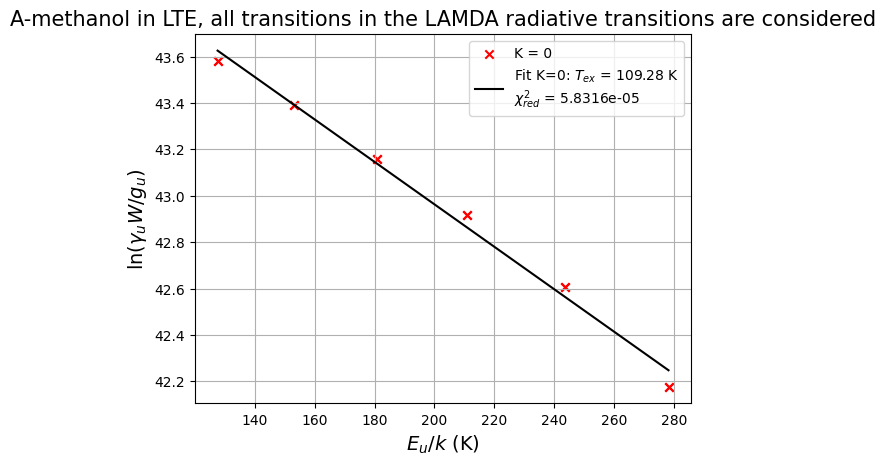

In [107]:
# Take only N first transitions
# firstN_transitions = 800

# calculate get y values using column density of the upper level
y_values_metanol_k0 = np.log(data_k0["Nu"] / data_k0["gu"])

# plot population diagram
fig, ax = plt.subplots()
plt.scatter(data_k0["Eu"], y_values_metanol_k0, marker="x", color="red", label="K = 0")

plt.xlabel(r"$E_u/k$ (K)", fontsize=14)
plt.ylabel(r"$\ln(\gamma_u W / g_u)$", fontsize=14)
plt.title("A-methanol in LTE, all transitions in the LAMDA radiative transitions are considered", fontsize=15)

# Fit a straight line to estimate T_ex for K=0
fit_k0 = np.polyfit(data_k0["Eu"], y_values_metanol_k0, 1)  # Linear fit
T_ex_k0 = -1 / fit_k0[0]  # Rotational temperature from slope

# Calculate the fitted y-values for K=0
x_fit_k0 = np.linspace(min(data_k0["Eu"]), max(data_k0["Eu"]), 100)
y_fit_k0 = fit_k0[0] * x_fit_k0 + fit_k0[1]

# Calculate chi-squared for K=0
y_fit_observed_k0 = fit_k0[0] * data_k0["Eu"] + fit_k0[1]
chi_squared_k0 = np.sum(((y_values_metanol_k0 - y_fit_observed_k0) ** 2) / y_fit_observed_k0)

# reduced chi_squared: chi_squared / (num_point - num_parameters), num_parameters = 1 for a straight line
chi_squared_red_k0 = chi_squared_k0 / (len(data_k0["Eu"]) - 2)

# Plot the best-fit line for K=0
plt.plot(
    x_fit_k0,
    y_fit_k0,
    linestyle="-",
    color="black",
    label=(f"Fit K=0: $T_{{ex}}$ = {T_ex_k0:.5g} K\n$\chi^2_{{red}}$ = {chi_squared_red_k0:.5g}"),
)

plt.legend()
ax.grid()
plt.show()
